In [20]:
import pandas as pd
import requests
import matplotlib

In [22]:

# Base URL for the API
base_url = "https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_MTBS_01/MapServer/63/query"

def fetch_data(years, lat_min, lat_max, lon_min, lon_max, offset=0, limit=1000):
    # Create a where clause to include only specific years
    year_filter = " OR ".join([f"YEAR={year}" for year in years])
    params = {
        'where': year_filter,
        'outFields': 'FIRE_ID,FIRE_NAME,YEAR,ACRES',
        'returnGeometry': 'true',
        'outSR': 4326,
        'f': 'json',
        'resultRecordCount': limit,
        'resultOffset': offset,
        'geometry': f'{{"xmin":{lon_min},"ymin":{lat_min},"xmax":{lon_max},"ymax":{lat_max}}}',
        'geometryType': 'esriGeometryEnvelope',
        'spatialRel': 'esriSpatialRelIntersects'
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    
    if 'features' in data and len(data['features']) > 0:
        records = []
        for feature in data['features']:
            attrs = feature['attributes']
            # Extract geometry coordinates (assuming polygons)
            geometry = feature.get('geometry', {})
            if geometry.get('rings'):
                # Assuming the first ring is the main polygon outline
                coordinates = geometry['rings'][0]
                # Take the average coordinate as a representative point
                if coordinates:
                    avg_lat = sum([point[1] for point in coordinates]) / len(coordinates)
                    avg_lon = sum([point[0] for point in coordinates]) / len(coordinates)
                    attrs['latitude'] = avg_lat
                    attrs['longitude'] = avg_lon
            records.append(attrs)
        return pd.DataFrame(records)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no records are found

# Define bounding box coordinates
lat_min = 32.0  # Minimum latitude
lat_max = 37.0  # Maximum latitude
lon_min = -120.0 # Minimum longitude
lon_max = -115.0 # Maximum longitude

# Initialize an empty DataFrame to store all records
all_records = pd.DataFrame()

# Fetch data for the years 2012 and 2022
years = [2012, 2022]
offset = 0
limit = 1000  # API limit

while True:
    df = fetch_data(years, lat_min, lat_max, lon_min, lon_max, offset, limit)
    if not df.empty:
        all_records = pd.concat([all_records, df], ignore_index=True)
        offset += limit  # Move to the next batch
    else:
        break  # Exit loop if no more data

# Display the DataFrame
print(all_records.head())
print(f"Total records fetched: {len(all_records)}")

# Display unique years
unique_years = all_records['YEAR'].astype(int).unique()
sorted_years = sorted(unique_years)
print("Years from earliest to latest:")
print(sorted_years)

all_records

                 FIRE_ID  FIRE_NAME  YEAR    ACRES   latitude   longitude
0  CA3633311865120220803     SUMMIT  2022   2266.0  36.329019 -118.655495
1  CA3261311670620220831  BORDER 32  2022   4530.0  32.609464 -116.656240
2  CA3371711689320220905   FAIRVIEW  2022  28680.0  33.676957 -116.865109
3  CA3451411862920220831      ROUTE  2022   5335.0  34.545041 -118.643723
4  CA3493411887620220622    THUNDER  2022   2586.0  34.922891 -118.894484
Total records fetched: 20
Years from earliest to latest:
[2012, 2022]


,FIRE_ID,FIRE_NAME,YEAR,ACRES,latitude,longitude
0,CA3633311865120220803,SUMMIT,2022,2266.0,36.329019,-118.655495
1,CA3261311670620220831,BORDER 32,2022,4530.0,32.609464,-116.656240
2,CA3371711689320220905,FAIRVIEW,2022,28680.0,33.676957,-116.865109
3,CA3451411862920220831,ROUTE,2022,5335.0,34.545041,-118.643723
4,CA3493411887620220622,THUNDER,2022,2586.0,34.922891,-118.894484
5,CA3418511691820220905,RADFORD,2022,1090.0,34.213471,-116.885535
6,CA3260811624320120517,BORDER 6,2012,5301.0,32.581808,-116.267738
7,CA3271011638520120617,OLD 2,2012,1058.0,32.694233,-116.366493
8,CA3306611643120120524,BANNER,2012,5371.0,33.050778,-116.452269
9,CA3312711649920120813,STEWART,2012,9501.0,33.137868,-116.487627


In [19]:
# Count the number of records for each year
year_counts = all_records['YEAR'].value_counts().sort_index()
print("Count of records for each year:")
print(year_counts)


Count of records for each year:
YEAR
2012    14
2022     6
Name: count, dtype: int64


In [23]:


# Assuming `all_records` is your DataFrame
csv_file_path = 'Output_Data/fire_data_2012_2022.csv'

# Save the DataFrame to a CSV file
all_records.to_csv(csv_file_path, index=False)

print(f"DataFrame has been saved to {csv_file_path}")


DataFrame has been saved to Output_Data/fire_data_2012_2022.csv


In [25]:
import folium
import plotly.express as px

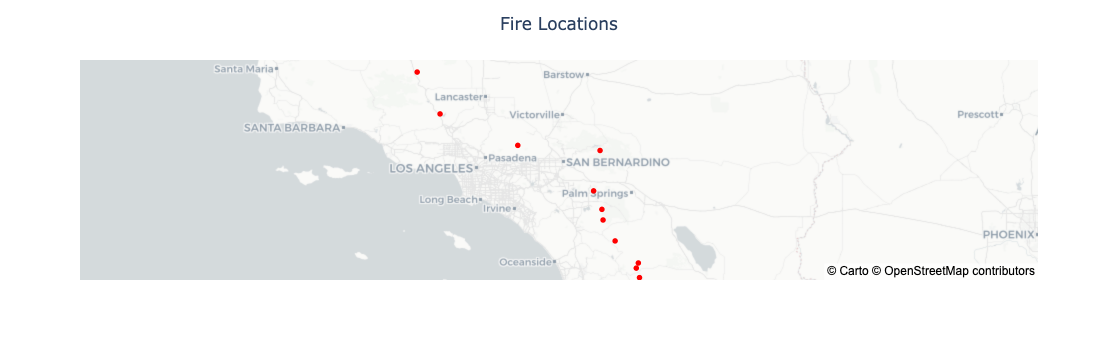

Plotly map has been saved to 'fire_map_plotly.html'


In [32]:
all_records = pd.read_csv('Output_Data/fire_data_2012_2022.csv')

# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    all_records,
    lat='latitude',
    lon='longitude',
    hover_name='FIRE_NAME',
    hover_data={'YEAR': True, 'ACRES': True},
    color_discrete_sequence=['red'],
    zoom=6,
    mapbox_style="carto-positron"
)

# Update layout to show title
fig.update_layout(
    title='Fire Locations',
    title_x=0.5
)

# Save to HTML
fig.write_html('Output_Data/fire_map_plotly.html')
fig.show()
print("Plotly map has been saved to 'fire_map_plotly.html'")

In [36]:
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point


In [37]:
# Assuming `all_records` DataFrame has latitude and longitude columns
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(all_records['longitude'], all_records['latitude'])]
gdf = gpd.GeoDataFrame(all_records, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Display the first few records
gdf.head()



,FIRE_ID,FIRE_NAME,YEAR,ACRES,latitude,longitude,geometry
0,CA3633311865120220803,SUMMIT,2022,2266.0,36.329019,-118.655495,POINT (-118.65550 36.32902)
1,CA3261311670620220831,BORDER 32,2022,4530.0,32.609464,-116.656240,POINT (-116.65624 32.60946)
2,CA3371711689320220905,FAIRVIEW,2022,28680.0,33.676957,-116.865109,POINT (-116.86511 33.67696)
3,CA3451411862920220831,ROUTE,2022,5335.0,34.545041,-118.643723,POINT (-118.64372 34.54504)
4,CA3493411887620220622,THUNDER,2022,2586.0,34.922891,-118.894484,POINT (-118.89448 34.92289)


<Axes: >

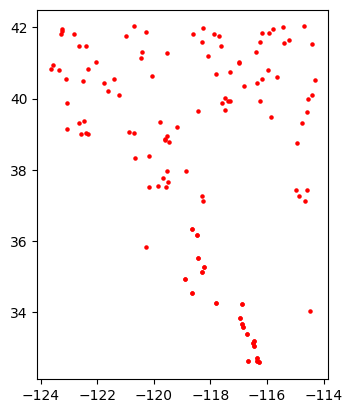

In [38]:
# Plot the fire locations
gdf.plot(marker='o', color='red', markersize=5)
